### **Project Title: Fine-Tuning ResNet50 on Oxford-IIIT Pet Dataset**  
**Description:**  
This project demonstrates the fine-tuning of a pre-trained ResNet50 model on the Oxford-IIIT Pet dataset. The dataset contains 37 classes of cats and dogs, and the goal is to classify images accurately into these categories. Using transfer learning, the ResNet50 model, pre-trained on ImageNet, was adapted to this specific task by modifying the final layers and optimizing the model for the pet classification problem. The notebook covers data preprocessing, model training, evaluation, and predictions on sample images.

Downloading module from GitHub by mrdbourke
use module in going_modular

In [1]:
import os

print("[INFO] Checking if required files and folders already exist.")

# ตรวจสอบว่ามีโฟลเดอร์ 'going_modular' และไฟล์ 'helper_functions.py' แล้วหรือไม่
if os.path.exists("going_modular") and os.path.exists("going_modular/helper_functions.py"):
    print("[INFO] Required files and folders already exist. Skipping download.")
else:
    print("[INFO] Downloading module from GitHub by mrdbourke.")
    # Clone repository
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    
    # Move 'going_modular' to the current directory
    !move pytorch-deep-learning\going_modular .
    
    # Move 'helper_functions.py' to the 'going_modular' folder
    !move pytorch-deep-learning\helper_functions.py going_modular
    
    # Remove the cloned repository
    !rmdir /s /q pytorch-deep-learning
    
    # Remove 'going_modular/models' folder if it exists
    !rmdir /s /q going_modular\models
    !rmdir /s /q pytorch-deep-learning
    print("[INFO] Download and setup completed.")
    


[INFO] Checking if required files and folders already exist.
[INFO] Downloading module from GitHub by mrdbourke.


Cloning into 'pytorch-deep-learning'...
Updating files:  54% (135/248)
Updating files:  55% (137/248)
Updating files:  56% (139/248)
Updating files:  57% (142/248)
Updating files:  58% (144/248)
Updating files:  59% (147/248)
Updating files:  60% (149/248)
Updating files:  61% (152/248)
Updating files:  62% (154/248)
Updating files:  63% (157/248)
Updating files:  64% (159/248)
Updating files:  65% (162/248)
Updating files:  66% (164/248)
Updating files:  67% (167/248)
Updating files:  68% (169/248)
Updating files:  69% (172/248)
Updating files:  70% (174/248)
Updating files:  71% (177/248)
Updating files:  72% (179/248)
Updating files:  73% (182/248)
Updating files:  74% (184/248)
Updating files:  75% (186/248)
Updating files:  76% (189/248)
Updating files:  77% (191/248)
Updating files:  78% (194/248)
Updating files:  79% (196/248)
Updating files:  80% (199/248)
Updating files:  81% (201/248)
Updating files:  82% (204/248)
Updating files:  83% (206/248)
Updating files:  84% (209/248)

        1 dir(s) moved.
        1 file(s) moved.
[INFO] Download and setup completed.


The system cannot find the file specified.


Import lib

In [1]:
import os
import torch 
import torchvision 
import matplotlib.pyplot as plt 
import pathlib
import torchvision.transforms as transforms
import pandas as pd
from going_modular.going_modular import data_setup,engine,utils
from going_modular.helper_functions import download_data, set_seeds, plot_loss_curves
from torch import nn
from torchinfo import summary
from pathlib import Path
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict ,Tuple


c:\ProgramData\anaconda3\envs\Deep_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup Device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Creating a model for resnet50 

In [3]:

def create_resnet50_model(num_classes:int=3,
                          seed:int=42,
                          dropout_rate: float = 0.3):  # เพิ่ม dropout_rate
  # 1. Setup pretrained ResNet50 weights
  weights = torchvision.models.ResNet50_Weights.DEFAULT  # Use the default weights
  
  # 2. Get ResNet50 transforms
  transforms = weights.transforms()
  
  # 3. Setup pretrained model instance
  model = torchvision.models.resnet50(weights=weights)  # Use the pretrained ResNet50
  
  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in model.parameters():
    param.requires_grad = False
  
  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  
  # เพิ่ม Dropout และกำหนด output เป็น num_classes
  model.fc = nn.Sequential(
    nn.Dropout(p=dropout_rate),  # เพิ่ม dropout
    nn.Linear(in_features=model.fc.in_features, out_features=num_classes, bias=True)
  )
  
  return model, transforms




call function create_resnet50_model()

In [4]:

resnet50_pets, resnet50_transforms = create_resnet50_model(num_classes=37,dropout_rate=0.3)

In [5]:
resnet50_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

# Print ResNet50 model summary (uncomment for full output)

In [6]:
summary(resnet50_pets,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 37]              --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

Create DataLoaders for resnet50 feature extractor

In [29]:
data_pet_path = Path("./img")
train_dir = data_pet_path / "train"
test_dir = data_pet_path / "test"
train_dir,test_dir

(WindowsPath('img/train'), WindowsPath('img/test'))

Check cpu core
Count cpu for use on num_workers

In [8]:
import os
os_cpu_count = os.cpu_count()
os_cpu_count

16

Setup resnet50 dataloaders

In [30]:
# Setup resnet50 dataloaders
from going_modular.going_modular import data_setup
train_dataloader_resnet50_pet_pretrained, test_dataloader_resnet50_pet_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=resnet50_transforms,
                                                                                                     batch_size=32,
                                                                                                     num_workers=16) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


checking batch size each dataloder from 
train_dataloader_pet_pretrained and test_dataloader_pet_pretrained

In [31]:
len(train_dataloader_resnet50_pet_pretrained),len(test_dataloader_resnet50_pet_pretrained),class_names[:10]

(149,
 47,
 ['Abyssinian',
  'Bengal',
  'Birman',
  'Bombay',
  'British_Shorthair',
  'Egyptian_Mau',
  'Maine_Coon',
  'Persian',
  'Ragdoll',
  'Russian_Blue'])

Training resnet50 Feature 
**`lr=1e-3 = 0.001`** is a suitable starting value, especially for medium to large models (e.g., ResNet or EfficientNet) and optimizers like Adam or AdamW.

In [32]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=resnet50_pets.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained resnet50 feature extractor model
set_seeds()
pretrained_resnet50_pets_results = engine.train(model=resnet50_pets,
                                      train_dataloader=train_dataloader_resnet50_pet_pretrained,
                                      test_dataloader=test_dataloader_resnet50_pet_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)

 20%|██        | 1/5 [02:59<11:59, 179.99s/it]

Epoch: 1 | train_loss: 1.7972 | train_acc: 0.6758 | test_loss: 0.8676 | test_acc: 0.8863


 40%|████      | 2/5 [06:03<09:06, 182.05s/it]

Epoch: 2 | train_loss: 0.5926 | train_acc: 0.9121 | test_loss: 0.5158 | test_acc: 0.9076


 60%|██████    | 3/5 [09:02<06:01, 180.51s/it]

Epoch: 3 | train_loss: 0.3820 | train_acc: 0.9339 | test_loss: 0.4159 | test_acc: 0.9062


 80%|████████  | 4/5 [11:57<02:58, 178.29s/it]

Epoch: 4 | train_loss: 0.2935 | train_acc: 0.9451 | test_loss: 0.3485 | test_acc: 0.9202


100%|██████████| 5/5 [14:50<00:00, 178.15s/it]

Epoch: 5 | train_loss: 0.2371 | train_acc: 0.9595 | test_loss: 0.3186 | test_acc: 0.9209


plot loss curves 

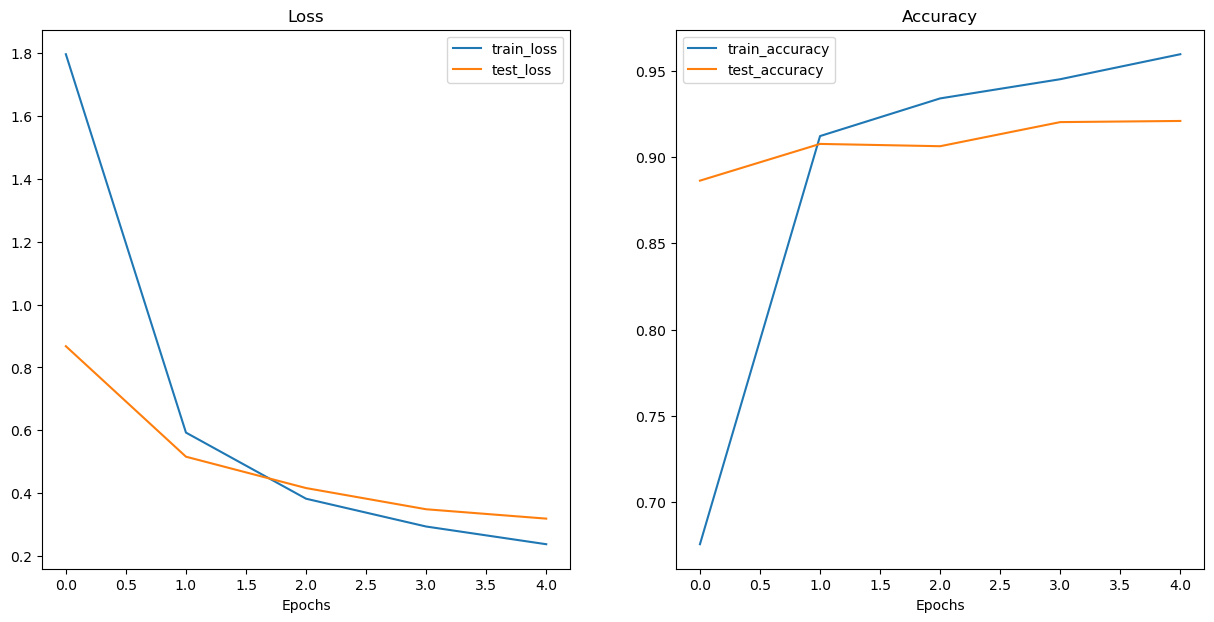

In [39]:
plot_loss_curves(pretrained_resnet50_pets_results)

Saving resnet50 model

In [40]:
utils.save_model(model=resnet50_pets,
                 target_dir="models",
                 model_name="pretrained_resnet50_pets.pth")

[INFO] Saving model to: models\pretrained_resnet50_pets.pth


Get the model size in bytes and convert to megabytes

In [41]:
pretrained_resnet50_model_size = Path("models/pretrained_resnet50_pets.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained Resnet50 feature extractor model size: {round(pretrained_resnet50_model_size, 2)} MB")

Pretrained Resnet50 feature extractor model size: 90.27 MB


Count number of parameters in model

In [42]:
resnet50_pets_total_params = sum(torch.numel(param) for param in resnet50_pets.parameters())
resnet50_pets_total_params

23583845

 Create a dictionary with Resnet50 Pet for keep records statistics

In [43]:
resnet50_pets_status = {"test_loss": pretrained_resnet50_pets_results["test_loss"][-1],
                  "test_acc": pretrained_resnet50_pets_results["test_acc"][-1],
                  "number_of_parameters": resnet50_pets_total_params,
                  "model_size (MB)": pretrained_resnet50_model_size}

resnet50_pets_status

{'test_loss': 0.3186375970377567,
 'test_acc': 0.9208776595744681,
 'number_of_parameters': 23583845,
 'model_size (MB)': 90.27348899841309}

Visualize Visualize Visualize data

Making predictions with our trained models and timing them

Making predictions with our trained models and timing them

In [46]:
# Get all test data img 
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[WindowsPath('img/test/Abyssinian/Abyssinian_100.jpg'),
 WindowsPath('img/test/Abyssinian/Abyssinian_109.jpg'),
 WindowsPath('img/test/Abyssinian/Abyssinian_115.jpg'),
 WindowsPath('img/test/Abyssinian/Abyssinian_116.jpg'),
 WindowsPath('img/test/Abyssinian/Abyssinian_119.jpg')]

Creating a function to make across the test dataset

In [49]:
# 1. สร้างฟังก์ชันที่รับรายการ paths, โมเดล PyTorch ที่ผ่านการฝึก, ชุด transforms, รายการชื่อคลาสเป้าหมาย และ target device
def pred_and_store(model: torch.nn.Module,
                  target_paths: List[pathlib.Path],
                  transforms: transforms.Compose,
                  class_names: List[str],
                  device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  # 2. สร้างลิสต์ว่าง (เพื่อเก็บผลการทำนายทั้งหมด)
  pred_list = []
  # 3. วนลูปในรายการ paths ที่ต้องการประมวลผล
  for path in tqdm(target_paths):
    # 4. สร้างดิกชันนารีว่างสำหรับแต่ละตัวอย่าง (เพื่อเก็บข้อมูลการทำนาย)
    pred_dict = {}
    # 5. ดึง path และ ground truth class (ground truth = "คำเฉลยคำตอบ") จาก filepath
    pred_dict["image_path"] = path
    pred_dict["ground_truth_class"] = path.parent.stem # `parent` ใช้สำหรับดึงชื่อโฟลเดอร์
    # 6.
    start_time = timer()
    # 7. เปิดภาพโดยใช้ `PIL.Image.open(path)`
    img = Image.open(path)
    # fix when img is not RGB( Grayscale ) -> convert to RGB
    if img.mode != "RGB":
        img = img.convert("RGB")
    # 8. ทำการแปลงภาพให้เหมาะสมกับโมเดล
    transformed_image = transforms(img).unsqueeze(0).to(device)
    # 9. ย้ายโมเดลไปที่ device ก่อนเริ่มลูป
    model = model.to(device)
    model.eval()
    # 10. ใช้ `torch.inference_mode()` และส่งภาพที่แปลงแล้วเข้าสู่โมเดลเพื่อคำนวณผลลัพธ์ + ความน่าจะเป็น (pred prob) + คลาสที่ทำนาย (pred class)
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # แปลงค่า logits ให้เป็นค่าความน่าจะเป็นของการทำนาย
      pred_label = torch.argmax(pred_prob, dim=1)  # แปลงค่าความน่าจะเป็นของการทำนายให้เป็นป้ายกำกับการทำนาย
      pred_class = class_names[pred_label.cpu()] # การกำหนดคลาสการทำนายให้ทำงานบน CPU (ตัวแปรใน Python จะถูกจัดเก็บอยู่บน CPU)
    # 11. เพิ่มข้อมูลความน่าจะเป็น + คลาสที่ทำนายลงในดิกชันนารีที่สร้างไว้ในข้อ 5
    pred_dict["pred_prob"] = round(pred_prob.squeeze(0).max().cpu().item(), 4)
    pred_dict["pred_class"] = pred_class
    # 12. หยุดจับเวลาที่เริ่มในข้อ 6 และเพิ่มเวลาในดิกชันนารี
    end_timer = timer()
    pred_dict["prediction_time"] = round(end_timer - start_time, 4)
    # 13. ตรวจสอบว่าคลาสที่ทำนายตรงกับคลาสจริงหรือไม่
    pred_dict["correct"] = pred_dict["ground_truth_class"] == pred_class
    # 14. เพิ่มดิกชันนารีที่อัปเดตแล้วไปในลิสต์ผลการทำนายที่สร้างไว้ในข้อ 2
    pred_list.append(pred_dict)

  # 15. คืนค่าลิสต์ผลการทำนาย
  return pred_list


In [51]:
#predict resnet50_pets
resnet50_pets_test_pred_dicts  = pred_and_store(model = resnet50_pets,
                         target_paths = test_data_paths,
                         transforms = resnet50_transforms,
                         class_names = class_names,
                         device = "cpu")


100%|██████████| 1479/1479 [02:14<00:00, 10.98it/s]


Turn the resnet50_pets_test_pred_dicts into DataFrame

In [53]:
resnet50_pets_test_pred_df = pd.DataFrame(resnet50_pets_test_pred_dicts)
resnet50_pets_test_pred_df.head()

,image_path,ground_truth_class,pred_prob,pred_class,prediction_time,correct
0,img\test\Abyssinian\Abyssinian_100.jpg,Abyssinian,0.5812,Abyssinian,0.1110,True
1,img\test\Abyssinian\Abyssinian_109.jpg,Abyssinian,0.5314,Abyssinian,0.0924,True
2,img\test\Abyssinian\Abyssinian_115.jpg,Abyssinian,0.6197,Abyssinian,0.1121,True
3,img\test\Abyssinian\Abyssinian_116.jpg,Abyssinian,0.5950,Abyssinian,0.1114,True
4,img\test\Abyssinian\Abyssinian_119.jpg,Abyssinian,0.5869,Abyssinian,0.0950,True


Check number of correct predictions

In [54]:
resnet50_pets_test_pred_df.correct.value_counts()

correct
True     1360
False     119
Name: count, dtype: int64

Find the avg time per prediction

In [55]:
resnet50_pets_average_time_per_pred  = round(resnet50_pets_test_pred_df.prediction_time.mean(),4)
print(f"avg per sec. predition : {resnet50_pets_average_time_per_pred}")

avg per sec. predition : 0.0907


Add time per pred to Resnet50 Pet stats dictionary record

In [56]:
resnet50_pets_status["time_per_pred_cpu"] = resnet50_pets_average_time_per_pred
resnet50_pets_status

{'test_loss': 0.3186375970377567,
 'test_acc': 0.9208776595744681,
 'number_of_parameters': 23583845,
 'model_size (MB)': 90.27348899841309,
 'time_per_pred_cpu': np.float64(0.0907)}

Create Function Plot Perdict random Image

In [57]:
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

Show random 5 image perdiction

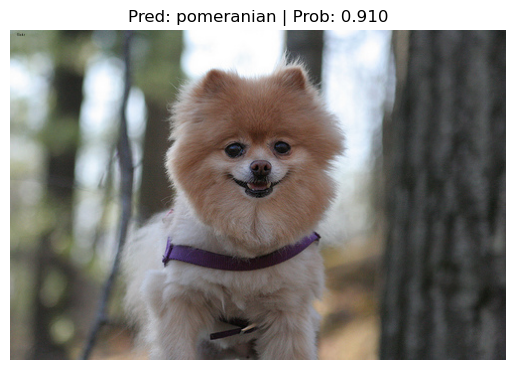

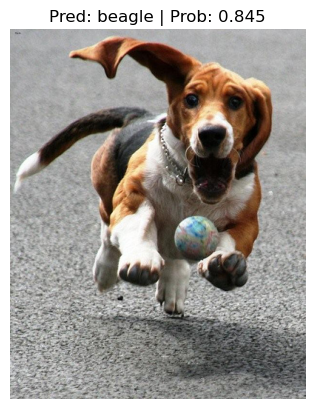

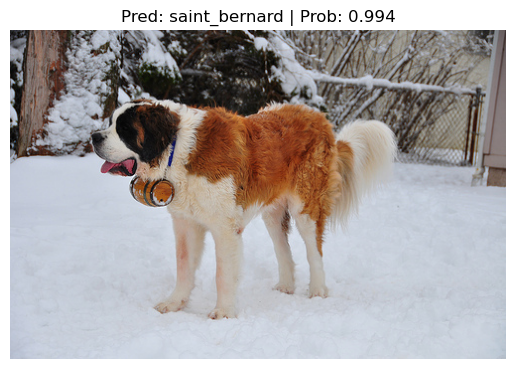

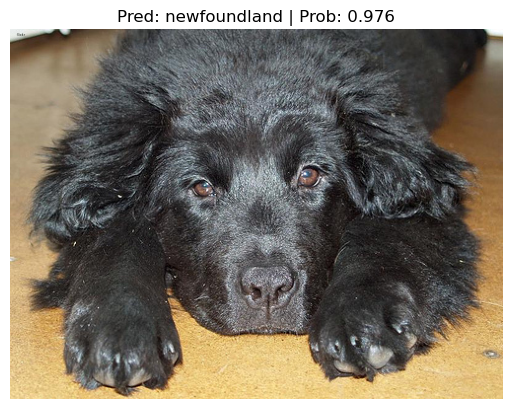

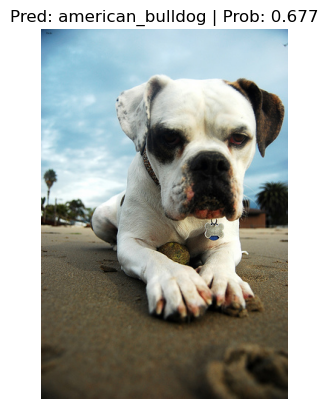

In [58]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 5
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=resnet50_pets, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

In [59]:
!echo "*.ipynb filter=nbstripout" > .gitattributes
!copy .gitattributes demos\

        0 file(s) copied.


The system cannot find the path specified.


### **Model Summary**  
The model achieved a **test accuracy of 92.09%** with a **test loss of 0.3186** on a 37-class classification task. It has **23,583,845 parameters** and a model size of **90.27 MB**, making it efficient for deployment.  

Out of **1,479 total predictions**, the model correctly predicted **1,360 images** and misclassified **119 images**, resulting in an **error rate of approximately 8.05%**.  

Further improvements could include fine-tuning with a lower learning rate, additional data augmentation, or error analysis for targeted enhancements.

Turning our Resnet50 Pet model into a deployable app via Hugingface

Create Folder demos/Resnet50_pet

In [60]:
import shutil
from pathlib import Path

#Create FoodVision big demo path
Resnet50_pet_demo_path = Path("demos")

#Remove files than might exist and create a new directorty (ถ้ามีไฟล์เก่าให้ลบและสร้างใหม่)
if Resnet50_pet_demo_path.exists():
  shutil.rmtree(Resnet50_pet_demo_path)
  Resnet50_pet_demo_path.mkdir(parents=True, exist_ok=True)
else:
  Resnet50_pet_demo_path.mkdir(parents=True, exist_ok=True)

create an examples directory

In [61]:
Resnet50_pet_examples_path = Resnet50_pet_demo_path / "examples"
Resnet50_pet_examples_path.mkdir(parents=True, exist_ok=True)

Move training Model to demos/Resnet50_pet

In [62]:
!copy models\pretrained_resnet50_pets.pth demos\

        1 file(s) copied.


create path to Resnet50 Pet class names

In [63]:
resnet50_pet_classname_path = Resnet50_pet_demo_path / "class_names.txt"
resnet50_pet_classname_path

WindowsPath('demos/class_names.txt')

Get classnames

In [64]:
resnet50_pet_classname = class_names
resnet50_pet_classname[:5]

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair']

Record classname to class_names.txt

In [65]:
# Write Restnet50 Pet class names to text file
with open(resnet50_pet_classname_path, "w") as f:
  print(f"[INFO] Saving Pet class names to {resnet50_pet_classname_path}")
  f.write("\n".join(resnet50_pet_classname)) # new line per class name

[INFO] Saving Pet class names to demos\class_names.txt


Open and Read

In [66]:
# Open resnet50 pet class names file and read each line into a list
with open(resnet50_pet_classname_path, "r") as f:
  resnet50_pet_classname_loaded = [pet.strip() for pet in f.readlines()]
resnet50_pet_classname_loaded[:5]

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair']

Turning our Resnet50 Pet model into a Python script (model.py)

In [67]:
%%writefile demos/model.py
import torch
import torchvision
from torch import nn

def create_resnet50_model(num_classes:int=3,
                          seed:int=42,
                          dropout_rate: float = 0.3):  # เพิ่ม dropout_rate
  # 1. Setup pretrained ResNet50 weights
  weights = torchvision.models.ResNet50_Weights.DEFAULT  # Use the default weights
  
  # 2. Get ResNet50 transforms
  transforms = weights.transforms()
  
  # 3. Setup pretrained model instance
  model = torchvision.models.resnet50(weights=weights)  # Use the pretrained ResNet50
  
  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in model.parameters():
    param.requires_grad = False
  
  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  
  # เพิ่ม Dropout และกำหนด output เป็น num_classes
  model.fc = nn.Sequential(
    nn.Dropout(p=dropout_rate),  # เพิ่ม dropout
    nn.Linear(in_features=model.fc.in_features, out_features=num_classes, bias=True)
  )
  
  return model, transforms




Writing demos/model.py


Turning our Resnet50 Pet Gradio app into a Python script (app.py)

In [68]:
%%writefile demos/app.py

# 1. imports and class names setup
import gradio as gr
import os
import torch
import torchvision


from model import create_resnet50_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:
  class_names = [pet.strip() for pet in f.readlines()]

# 2. model and transforms preparation
resnet50_pets, resnet50_transforms = create_resnet50_model(num_classes=37)

# Load saved weights
resnet50_pets.load_state_dict(
    torch.load(
        f="pretrained_resnet50_pets.pth",
        map_location=torch.device("cpu") # load the model to the CPU
    )
)

from typing import Tuple, Dict
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = resnet50_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  resnet50_pets.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(resnet50_pets(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  # ความน่าจะเป็นการทำนาย (prediction probability)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time


#create a example list
example_list = ["examples/" + example for example in os.listdir("examples")]
example_list


title = "Resnet50 Pet 🐶🐱🐈"
description = "An Resnet50 feature extractor computer vision model to classify Pet images into 37 classes Dog & Cat"
article = " Created at [https://github.com/raksitkan/Pytorch_vision_Pet])."
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)
demo.launch()

Writing demos/app.py


Create a requirements file for resnet50 pet (requirements.txt)

In [69]:
import gradio as gr
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"torchvision version: {gr.__version__}")

torch version: 2.5.1
torchvision version: 0.20.1
torchvision version: 5.7.1


In [70]:
%%writefile demos/requirements.txt
torch==2.5.1
torchvision==0.20.1
gradio==5.7.1


Writing demos/requirements.txt


Zip file demos for upload to huggingface

In [71]:
import shutil

shutil.make_archive('demos', 'zip', 'demos')


'c:\\resnet\\resnet50_pet\\demos.zip'

See our Porject below

In [72]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://raksitkan-resnet50-pet-classifier.hf.space", width=900, height=750)